Neural Networks


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

# Create a dictionary to store data for each horizon
test_data = {}
horizons = [1, 5, 21]

# Load test data for each horizon
for horizon in horizons:
    # Define the file path
    file_path = f'C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_h{horizon}.csv'
    
    # Load the data and store it in the dictionary
    test_data[horizon] = pd.read_csv(file_path)
    
    # Print confirmation and info about the loaded data
    print(f"Loaded test_data_h{horizon}: {test_data[horizon].shape}")
    print(f"Columns: {test_data[horizon].columns.tolist()[:10]}...")  # First 10 columns
    print("-" * 50)

# Extract option-only features for each horizon
option_columns = [
    'cp_flag',
    'stock_price',
    'moneyness',
    'time_to_expiry',
    'strike_price',
    'rf',
    'delta',
    'gamma',
    'vega',
    'theta',
    'iv_ahbs',
    'iv_ahbs_error',
    'iv_bs',
    'iv_bs_error',
    'iv_cw',
    'iv_cw_error',
    'impl_volatility'
]

# Create option-only datasets for each horizon
option_only_data = {}
for horizon in horizons:
    test_data[horizon] = test_data[horizon][option_columns].copy()
    print(f"\nOption-only data for horizon {horizon}:")
    print(f"Shape: {test_data[horizon].shape}")
    print(test_data[horizon].head())
    print("-" * 50)

train_data = pd.read_csv('C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_train.csv')
# Drop the date column
train_data = train_data.drop(columns=['date', 'moneyness_category'])
train_data = train_data[option_columns]
print(f"\nTrain data:")
print(f"Shape: {train_data.shape}")

Loaded test_data_h1: (2571058, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h5: (2203398, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h21: (1341910, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------

Option-only data for horizon 1:
Shape: (2571058, 17)
   cp_flag  stock_price  moneyness  time_to_expiry  strike_price      rf  \
0        1      115.545   0.996078              23         116.0  0.0245   
1        1      115.545   0.987564              23         117.0  0.0245   
2        1      115.545   0.979195              23 

In [2]:
###########################################
# PART 1: NEURAL NETWORK MODEL DEFINITION
###########################################

def create_nn_model(architecture_type, input_dim):
    """
    Create neural network models with architectures based on the geometric pyramid rule.
    
    Parameters:
    architecture_type (str): One of 'NN3' or 'NN4', specifying which architecture to use
    input_dim (int): Dimension of the input features
    
    Returns:
    model: Compiled Keras model with specified architecture
    """
    model = Sequential()
    
    # Define architecture based on specifications
    if architecture_type == 'NN3':
        # Three hidden layers with 32, 16, and 8 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(1))
    
    elif architecture_type == 'NN4':
        # Four hidden layers with 32, 16, 8, and 4 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    else:
        raise ValueError("Invalid architecture type. Choose from 'NN3' or 'NN4'.")
    
    # Compile model with Adam optimizer for faster training
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    
    return model

def train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=50):
    """
    Train and evaluate a neural network model with optimizations for faster training.
    
    Parameters:
    model: Compiled Keras model
    X_train_scaled: Scaled training features
    y_train: Training target values
    X_test_scaled: Scaled test features
    y_test: Test target values
    epochs: Maximum number of training epochs
    
    Returns:
    history: Training history
    mse: Mean squared error on test data
    """
    # Early stopping with optimized parameters
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )
    ]
    
    # Train model with larger batch size for better speed
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=0.0,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_scaled, batch_size=128, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    
    return history, mse


In [3]:
###########################################
# PART 2: DATA PREPARATION
###########################################

import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(option_only, save_paths=True):
    # 1) Define features & targets
    exclude = [
        'iv_bs_error', 'iv_ahbs', 'iv_ahbs_error', 'iv_bs',
        'iv_cw', 'iv_cw_error', 'impl_volatility', 'ID'
    ]
    exclude_cols = [
        'iv_bs_error', 'iv_ahbs', 'iv_ahbs_error',
        'iv_bs', 'iv_cw', 'iv_cw_error',
        'impl_volatility'
    ]
    features = [col for col in option_only.columns if col not in exclude_cols]
    X_train = option_only[features]
    y_train = {
        'bs': option_only['iv_bs_error'],
        'ahbs': option_only['iv_ahbs_error'],
        'cw': option_only['iv_cw_error']
    }

    # 3) Scale training data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=features
    )

    # 4) Persist artifacts if required
    if save_paths:
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(features, 'feature_columns.pkl')

    return X_train_scaled, y_train, scaler, features



In [4]:
def predict_and_add_to_test_data(models, test_data, feature_columns, scaler, error_type):
    """
    Prepare test data, generate predictions and add them to the test dataset.
   
    Parameters:
    models (dict): Dictionary containing trained models with keys as model names
    test_data (pandas.DataFrame): Test dataset to make predictions on
    scaler (StandardScaler): Fitted scaler to transform the test features
    feature_columns (list): List of column names to use as features
    error_type (str): Type of error being predicted ('bs', 'ahbs', or 'cw')
   
    Returns:
    pandas.DataFrame: Test dataset with added prediction columns
    """
    # Create a copy of the test data to avoid modifying the original
    result_df = test_data.copy()
   
    # Extract features from test data as DataFrame (not as numpy array)
    X_test = test_data[feature_columns]
   
    # Scale the features using the pre-fitted scaler and convert back to DataFrame
    # This preserves feature names and prevents the warning
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_columns,
        index=X_test.index
    )
   
    # Original value column name
    original_column = f'iv_{error_type}'
   
    # Generate predictions for each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test_scaled, batch_size=128, verbose=0)
       
        # Flatten predictions if needed
        if len(predictions.shape) > 1:
            predictions = predictions.flatten()
       
        # Add predictions to the dataframe
        column_name = f'iv_{error_type}_pred_{model_name}'
        result_df[column_name] = predictions
       
        # Calculate corrected value by adding the error prediction to the original value
        result_df[f'iv_{error_type}_corrected_{model_name}'] = result_df[original_column] + predictions
   
    return result_df

In [ ]:

###########################################
# PART 4: COMPLETE WORKFLOW
###########################################

if __name__ == "__main__":
    # Step 1: Load data
    # Assuming option_only and test_data_h1 are loaded from CSV
    # option_only = pd.read_csv('option_data.csv')
    # test_data_h1 = pd.read_csv('test_data_h1.csv')
    
    # Step 2: Prepare data
    X_train_scaled, X_test_scaled, y_train_dict, y_test_dict, scaler, feature_columns = prepare_data(train_data)
    
    # Step 3: Train models for each target variable
    models = {}
    results = {}
    
    # Dictionary to store all models
    loaded_models = {
        'bs': {},
        'ahbs': {},
        'cw': {}
    }
    
    # Train models for each error type
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"\n=== Training models for {error_type} error correction ===")
        
        # Get the appropriate training and test targets
        y_train = y_train_dict[error_type]
        y_test = y_test_dict[error_type]
        
        # Train each architecture
        for nn_type in ['NN3', 'NN4']:
            model_name = f"{nn_type}_{error_type}"
            print(f"\nTraining {model_name}...")
            
            # Create model
            model = create_nn_model(nn_type, X_train_scaled.shape[1])
            
            # Train and evaluate model
            history, mse = train_and_evaluate_model(
                model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=50
            )
            
            # Store model and results
            loaded_models[error_type][nn_type] = model
            results[model_name] = {
                'mse': mse,
                'history': history
            }
            
            print(f"{model_name} Test MSE: {mse}")
            
            # Save model
            save_model(model, f"{model_name}_model_forecast.h5")
    
    # Step 4: Generate predictions on new test data for each error type



=== Training models for bs error correction ===

Training NN3_bs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 659us/step - loss: 0.0052 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 652us/step - loss: 0.0025 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 654us/step - loss: 0.0022 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 649us/step - loss: 0.0021 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 647us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 647us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 655us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 652us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 651us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 658us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 11/50
16686/1

NN3_bs Test MSE: 0.0013839819703867768

Training NN4_bs...
Epoch 1/50


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 675us/step - loss: 0.0047 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 677us/step - loss: 0.0024 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 703us/step - loss: 0.0022 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 697us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 674us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 681us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 672us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 680us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 693us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 674us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 11/50
16686/16686 ━━━━━━

NN4_bs Test MSE: 0.001376753834286378

=== Training models for ahbs error correction ===

Training NN3_ahbs...
Epoch 1/50


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 718us/step - loss: 0.0060 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 712us/step - loss: 0.0022 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 706us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 704us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 701us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 707us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 705us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 704us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 705us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 704us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 11/50
16686/16686 ━━━━━━

NN3_ahbs Test MSE: 0.0014036958794976084

Training NN4_ahbs...
Epoch 1/50


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 733us/step - loss: 0.0039 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 735us/step - loss: 0.0022 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 732us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 731us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 730us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 728us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 731us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 730us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 730us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 729us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 11/50
16686/16686 ━━━━━━

NN4_ahbs Test MSE: 0.001337126481257723

=== Training models for cw error correction ===

Training NN3_cw...
Epoch 1/50


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 711us/step - loss: 0.0068 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 715us/step - loss: 0.0021 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 701us/step - loss: 0.0019 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 669us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 702us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 646us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 643us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 641us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 645us/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 11s 644us/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 11/50
16686/16686 ━━━━━━

NN3_cw Test MSE: 0.001251542490246307

Training NN4_cw...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 746us/step - loss: 0.0040 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 732us/step - loss: 0.0020 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 748us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 745us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 722us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 729us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 743us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 748us/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 742us/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 746us/step - loss: 0.0016 - learning_rate: 0.0100
Epoch 11/50
16686/1

NN4_cw Test MSE: 0.0012461470439680484


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def load_models(model_paths_dict):
    """
    Load models individually and check if they're loaded correctly
    
    Parameters:
    model_paths_dict: dict - Dictionary with error types and model paths
    
    Returns:
    Dictionary with loaded models
    """
    loaded_models = {}
    
    for error_type in model_paths_dict:
        loaded_models[error_type] = {}
        
        for model_name, path in model_paths_dict[error_type].items():
            try:
                # Handle Windows paths by using raw strings
                path = path.replace('\\', '/')  # Convert backslashes to forward slashes
                
                # Check if file exists
                if not os.path.exists(path):
                    print(f"✗ {error_type} {model_name}: File not found at {path}")
                    loaded_models[error_type][model_name] = None
                    continue
                
                # Load the model
                print(f"Loading {error_type} {model_name}...")
                model = load_model(path)
                
                # Simple check: can we access layers?
                num_layers = len(model.layers)
                print(f"✓ Model loaded successfully with {num_layers} layers")
                
                # Store loaded model
                loaded_models[error_type][model_name] = model
                
            except Exception as e:
                print(f"✗ Failed to load {error_type} {model_name}: {str(e)}")
                loaded_models[error_type][model_name] = None
    
    return loaded_models

# Example usage
if __name__ == "__main__":
    # Model paths dictionary with proper path handling for Windows
    # Use forward slashes or raw strings to avoid Unicode escape errors
    model_paths_dict = {
    'bs': {
        'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN3_bs_model_forecast.h5",
        'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN4_bs_model_forecast.h5"
    },
    'ahbs': {
        'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN3_ahbs_model_forecast.h5",
        'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN4_ahbs_model_forecast.h5"
    },
    'cw': {
        'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN3_cw_model_forecast.h5",
        'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Option Only/NN4_cw_model_forecast.h5"
    }
    }

    
    # Load all models
    loaded_models = load_models(model_paths_dict)
    
    # Print summary of loaded models
    print("\n=== Model Loading Summary ===")
    for error_type in loaded_models:
        for model_name in loaded_models[error_type]:
            status = "✓ Loaded" if loaded_models[error_type][model_name] is not None else "✗ Failed"
            print(f"{error_type} {model_name}: {status}")

Loading bs NN3...
✓ Model loaded successfully with 4 layers
Loading bs NN4...


✓ Model loaded successfully with 5 layers
Loading ahbs NN3...


✓ Model loaded successfully with 4 layers
Loading ahbs NN4...
✓ Model loaded successfully with 5 layers
Loading cw NN3...
✓ Model loaded successfully with 4 layers
Loading cw NN4...
✓ Model loaded successfully with 5 layers

=== Model Loading Summary ===
bs NN3: ✓ Loaded
bs NN4: ✓ Loaded
ahbs NN3: ✓ Loaded
ahbs NN4: ✓ Loaded
cw NN3: ✓ Loaded
cw NN4: ✓ Loaded


In [6]:
test_data_per_horizon = {}

scaler_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network forecast\Option Only\scaler.pkl"
scaler = joblib.load(scaler_path)

for horizon in horizons:
    # 1) load and copy base test set
    print(f"\n=== Horizon {horizon} ===")
    base_df = test_data[horizon].copy()
    
    # 2) determine your features once
    exclude_cols = [
        'iv_bs_error','iv_ahbs','iv_ahbs_error','iv_bs','iv_cw','iv_cw_error',
        'impl_volatility','moneyness_category','ID','date','new_id',
        'open_interest','option_price','prediction_horizon',
        'test_date','train_date','volume'
    ]
    feature_columns = [c for c in base_df.columns if c not in exclude_cols]
    
    # 3) loop over error types _and_ models, but update the SAME DataFrame
    df = base_df
    for error_type in ['bs','ahbs','cw']:
        print(f"\n-- predicting corrections for {error_type} --")
        
        models_for_type = loaded_models[error_type]  # e.g. [nn3_model, nn4_model]
        
        # assume your helper loops through each model internally,
        # adding both iv_{error_type}_pred_NN3/_NN4 and iv_{error_type}_corrected_NN3/_NN4
        df = predict_and_add_to_test_data(
            models_for_type, df, feature_columns, scaler, error_type
        )
        
        # show a quick peek
        cols = ['impl_volatility', f'iv_{error_type}']
        for m in ['NN3','NN4']:
            cols += [f'iv_{error_type}_pred_{m}', f'iv_{error_type}_corrected_{m}']
        print(df[cols].head(3))
    
    # 4) after all error types, assign once
    test_data_per_horizon[horizon] = df.copy()
    print(f"\n-- test_data_h{horizon} updated --")


=== Horizon 1 ===

-- predicting corrections for bs --
   impl_volatility     iv_bs  iv_bs_pred_NN3  iv_bs_corrected_NN3  \
0         0.201081  0.288808       -0.067746             0.221061   
1         0.196421  0.288808       -0.070230             0.218578   
2         0.191262  0.288808       -0.073009             0.215799   

   iv_bs_pred_NN4  iv_bs_corrected_NN4  
0       -0.059932             0.228875  
1       -0.061419             0.227388  
2       -0.064304             0.224503  

-- predicting corrections for ahbs --
   impl_volatility   iv_ahbs  iv_ahbs_pred_NN3  iv_ahbs_corrected_NN3  \
0         0.201081  0.299345         -0.067541               0.231804   
1         0.196421  0.298947         -0.067420               0.231526   
2         0.191262  0.298851         -0.067552               0.231299   

   iv_ahbs_pred_NN4  iv_ahbs_corrected_NN4  
0         -0.059653               0.239693  
1         -0.062463               0.236484  
2         -0.065009               0.

BASE IVRMSE

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_ivrmse(predictions_df, error_types=['bs', 'ahbs', 'cw'], models=['NN3', 'NN4']):
    results = {}
    
    # Calculate IVRMSE for each error type and model
    for error_type in error_types:
        orig_col = f'iv_{error_type}'
        
        # Calculate base IVRMSE (before correction)
        base_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[orig_col]))
        results[f"{error_type}_base"] = base_rmse
        
        # Calculate IVRMSE for each model
        for model in models:
            corrected_col = f'iv_{error_type}_corrected_{model}'
            
            # Skip if corrected column doesn't exist
            if corrected_col not in predictions_df.columns:
                print(f"Warning: {corrected_col} column not found, skipping...")
                continue
                
            # Calculate IVRMSE for the corrected predictions
            corrected_diff = predictions_df['impl_volatility'] - predictions_df[corrected_col]
            corrected_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[corrected_col]))
            results[f"{error_type}_{model}"] = corrected_rmse
            
            # Calculate improvement percentage
            improvement = (base_rmse - corrected_rmse) / base_rmse * 100
            results[f"{error_type}_{model}_improvement"] = improvement
    
    return results

import pandas as pd

def build_vertical_ivrmse_table(horizons, test_data):
    all_panels = []

    for horizon in horizons:
        ivrmse_results = calculate_ivrmse(test_data[horizon])
        records = []
        for error_type in ['bs', 'ahbs', 'cw']:
            row = []
            base_key = f"{error_type}_base"
            row.append(ivrmse_results.get(base_key, None))
            for model in ['NN3', 'NN4']:
                model_key = f"{error_type}_{model}"
                row.append(ivrmse_results.get(model_key, None))
            records.append(row)

        df = pd.DataFrame(records, 
                          index=['BS', 'AHBS', 'CW'], 
                          columns=['Base', 'NN3', 'NN4'])
        df['Horizon'] = horizon
        all_panels.append(df.reset_index())

    combined_df = pd.concat(all_panels)
    combined_df.rename(columns={'index': 'Error_Type'}, inplace=True)

    # Save to CSV
    output_path = "ivrmse_nm_nn_f_o.csv"
    combined_df.to_csv(output_path, index=False)
    print(f"Saved combined results to {output_path}")

    return combined_df

# Generate and save
combined_csv_df = build_vertical_ivrmse_table(horizons, test_data_per_horizon)


Saved combined results to ivrmse_nm_nn_f_o.csv


Calculate IVRMSE

In [13]:
def add_moneyness_categories(df):
    # Create a copy to avoid modifying the original dataframe
    result = df.copy()
    
    # Initialize moneyness_category column with NaN values
    result['moneyness_category'] = np.nan
    
    # Define conditions for each category
    dotmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.80) & (result['moneyness'] < 0.90)
    otmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.90) & (result['moneyness'] < 0.97)
    atm_mask = (result['moneyness'] >= 0.97) & (result['moneyness'] < 1.03)
    otmp_mask = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.03) & (result['moneyness'] < 1.10)
    dotmp_mask = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.10) & (result['moneyness'] <= 1.60)
    
    # Assign categories based on conditions
    result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'
    result.loc[otmc_mask, 'moneyness_category'] = 'OTMC'
    result.loc[atm_mask, 'moneyness_category'] = 'ATM'
    result.loc[otmp_mask, 'moneyness_category'] = 'OTMP'
    result.loc[dotmp_mask, 'moneyness_category'] = 'DOTMP'
    
    return result

for horizon in [1, 5, 21]:
    # Apply moneyness categorization
    test_data_per_horizon[horizon] = add_moneyness_categories(test_data_per_horizon[horizon])
    print(f"Added moneyness categories to test_data_per_horizon[{horizon}]")
        
     # Print sample data to verify
    display_columns = ['cp_flag', 'moneyness', 'moneyness_category']
    print(f"\nSample data for horizon {horizon}:")
    print(test_data_per_horizon[horizon][display_columns].head(5))

C:\Users\maxva\AppData\Local\Temp\ipykernel_24288\3020456291.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'


Added moneyness categories to test_data_per_horizon[1]

Sample data for horizon 1:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC


C:\Users\maxva\AppData\Local\Temp\ipykernel_24288\3020456291.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'
C:\Users\maxva\AppData\Local\Temp\ipykernel_24288\3020456291.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'


Added moneyness categories to test_data_per_horizon[5]

Sample data for horizon 5:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC
Added moneyness categories to test_data_per_horizon[21]

Sample data for horizon 21:
   cp_flag  moneyness moneyness_category
0        1   0.962875               OTMC
1        1   0.924360               OTMC
2        1   0.888808              DOTMC
3        1   0.855889              DOTMC
4        0   1.155450              DOTMP


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['NN3', 'NN4']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):
    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    improvement_df = pd.DataFrame(improvement_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} NN3", f"{et} NN4"])
        improvement_cols.extend([f"{et} NN3", f"{et} NN4"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    improvement_df = improvement_df[[col for col in improvement_cols if col in improvement_df.columns]]
    
    return ivrmse_df, improvement_df

def find_best_models(results):
    best_models = []
    
    for group, group_results in results.items():
        for error_type in ['bs', 'ahbs', 'cw']:
            # Get baseline IVRMSE
            base_key = f"{error_type}_base"
            if base_key not in group_results:
                continue
                
            base_rmse = group_results[base_key]
            
            # Find best model for this error type
            models = [m for m in ['NN3', 'NN4'] if f"{error_type}_{m}" in group_results]
            if not models:
                continue
            
            # Find model with lowest IVRMSE    
            best_model = min(models, key=lambda m: group_results[f"{error_type}_{m}"])
            best_rmse = group_results[f"{error_type}_{best_model}"]
            improvement = group_results[f"{error_type}_{best_model}_improvement"]
            
            # Also get the values for the other model for comparison
            other_models = [m for m in models if m != best_model]
            other_model_data = {}
            if other_models:
                other_model = other_models[0]
                other_rmse = group_results[f"{error_type}_{other_model}"]
                other_improvement = group_results[f"{error_type}_{other_model}_improvement"]
                other_model_data = {
                    f'Other Model': other_model,
                    f'Other IVRMSE': other_rmse,
                    f'Other Improvement %': other_improvement
                }
            
            model_data = {
                'Moneyness Group': group,
                'Error Type': error_type.upper(),
                'Best Model': best_model,
                'Base IVRMSE': base_rmse,
                'Best IVRMSE': best_rmse,
                'Improvement %': improvement
            }
            
            # Add other model data if available
            model_data.update(other_model_data)
            
            best_models.append(model_data)
    
    return pd.DataFrame(best_models)

def print_formatted_tables(results):
    """
    Print formatted tables from the analysis results.
    
    Parameters:
    results (dict): Results from analyze_ivrmse_by_moneyness function
    """
    # Format results into DataFrames
    ivrmse_df, improvement_df = format_results_table(results)
    
    # Format IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))
    
    # Format improvement table
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))
    
    # Find best models
    best_models_df = find_best_models(results)
    
    # Reset float format for mixed table
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    # Format specific columns
    best_models_df['Base IVRMSE'] = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE'] = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %'] = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    # Count best model occurrences
    model_counts = best_models_df['Best Model'].value_counts()
    print(f"Overall best model distribution: {dict(model_counts)}")
    
    # Average improvement by moneyness group
    print("\nAverage improvement by moneyness group:")
    # Convert percentage strings to numeric values
    best_models_df['Improvement_Numeric'] = pd.to_numeric(best_models_df['Improvement %'].str.rstrip('%'))
    
    # Group and calculate means
    avg_improvement = best_models_df.groupby('Moneyness Group')['Improvement_Numeric'].mean()
    
    # Handle the case where there's only one group (which returns a scalar)
    if isinstance(avg_improvement, pd.Series):
        # Sort if it's a Series with multiple values
        sorted_improvements = avg_improvement.sort_values(ascending=False)
        for group, imp in sorted_improvements.items():
            print(f"  {group}: {imp:.2f}%")
    else:
        # Just print the single value if it's a scalar
        group = best_models_df['Moneyness Group'].iloc[0]
        print(f"  {group}: {avg_improvement:.2f}%")

# Example usage:
results_h1 = analyze_ivrmse_by_moneyness(test_data_per_horizon[1])
results_h5 = analyze_ivrmse_by_moneyness(test_data_per_horizon[5])
results_h21 = analyze_ivrmse_by_moneyness(test_data_per_horizon[21])
print(results_h1)

# To get the results as DataFrames for further analysis:
#ivrmse_df, improvement_df = format_results_table(results)
#best_models_df = find_best_models(results)

{'DOTMC': {'bs_base': np.float64(0.12766750645454028), 'bs_NN3': np.float64(0.048082697184243885), 'bs_NN3_improvement': np.float64(62.33756065301932), 'bs_NN4': np.float64(0.04758303456569944), 'bs_NN4_improvement': np.float64(62.72893871970252), 'ahbs_base': np.float64(0.12243300045171161), 'ahbs_NN3': np.float64(0.04214205550787945), 'ahbs_NN3_improvement': np.float64(65.57949625313596), 'ahbs_NN4': np.float64(0.04177341991175929), 'ahbs_NN4_improvement': np.float64(65.88058794798955), 'cw_base': np.float64(0.11351418965472203), 'cw_NN3': np.float64(0.039619935290992815), 'cw_NN3_improvement': np.float64(65.09693157172207), 'cw_NN4': np.float64(0.0394289696983207), 'cw_NN4_improvement': np.float64(65.26516216320405)}, 'OTMC': {'bs_base': np.float64(0.11784078504428586), 'bs_NN3': np.float64(0.04148666334635555), 'bs_NN3_improvement': np.float64(64.79430841303), 'bs_NN4': np.float64(0.041472480435049836), 'bs_NN4_improvement': np.float64(64.80634406885186), 'ahbs_base': np.float64(0.

In [15]:
# 1) Change the signature to accept horizon
def print_formatted_tables(results, horizon):
    """
    Print formatted tables from the analysis results.
    
    Parameters:
    results (dict): Results from analyze_ivrmse_by_moneyness function
    horizon (int):    The forecast horizon (for display only)
    """
    ivrmse_df, improvement_df = format_results_table(results)
    
    # IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))

    # Improvement %
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))

    # Best models & summary (same as before)…
    best_models_df = find_best_models(results)
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    best_models_df['Base IVRMSE']    = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE']    = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %']  = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))

    # Summary statistics (same as before)…
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    # (rest of your summary code)

# 2) Now loop over all horizons:
all_results = {
    1: analyze_ivrmse_by_moneyness(test_data_per_horizon[1]),
    5: analyze_ivrmse_by_moneyness(test_data_per_horizon[5]),
    21: analyze_ivrmse_by_moneyness(test_data_per_horizon[21])
}

for h, res in all_results.items():
    print_formatted_tables(res, h)


IVRMSE by Moneyness Group (Horizon: 1)
Moneyness Group  BS Base   BS NN3   BS NN4  AHBS Base  AHBS NN3  AHBS NN4  CW Base   CW NN3   CW NN4
          DOTMC 0.127668 0.048083 0.047583   0.122433  0.042142  0.041773 0.113514 0.039620 0.039429
           OTMC 0.117841 0.041487 0.041472   0.110103  0.040232  0.039574 0.108715 0.038617 0.038419
            ATM 0.115332 0.039656 0.039798   0.110987  0.041039  0.040081 0.108876 0.040338 0.040145
           OTMP 0.108485 0.039676 0.039802   0.106252  0.041964  0.040876 0.105232 0.040475 0.040418
          DOTMP 0.169017 0.043924 0.043725   0.117603  0.047614  0.046505 0.112094 0.045202 0.045236

Improvement Percentage by Moneyness Group
Moneyness Group  BS NN3  BS NN4  AHBS NN3  AHBS NN4  CW NN3  CW NN4
          DOTMC  62.34%  62.73%    65.58%    65.88%  65.10%  65.27%
           OTMC  64.79%  64.81%    63.46%    64.06%  64.48%  64.66%
            ATM  65.62%  65.49%    63.02%    63.89%  62.95%  63.13%
           OTMP  63.43%  63.31%    60.51

In [16]:
# 1) Change the signature to accept horizon
def print_formatted_tables(results = results_h1, horizon =  1):
    """
    Print formatted tables from the analysis results.
    
    Parameters:
    results (dict): Results from analyze_ivrmse_by_moneyness function
    horizon (int):    The forecast horizon (for display only)
    """
    ivrmse_df, improvement_df = format_results_table(results)
    
    # IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))

    # Improvement %
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))

    # Best models & summary (same as before)…
    best_models_df = find_best_models(results)
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    best_models_df['Base IVRMSE']    = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE']    = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %']  = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))

    # Summary statistics (same as before)…
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    # (rest of your summary code)

# 2) Now loop over all horizons:
all_results = {
    1: analyze_ivrmse_by_moneyness(test_data_per_horizon[1]),
    5: analyze_ivrmse_by_moneyness(test_data_per_horizon[5]),
    21: analyze_ivrmse_by_moneyness(test_data_per_horizon[21])
}

for h, res in all_results.items():
    print_formatted_tables(res, h)


IVRMSE by Moneyness Group (Horizon: 1)
Moneyness Group  BS Base   BS NN3   BS NN4  AHBS Base  AHBS NN3  AHBS NN4  CW Base   CW NN3   CW NN4
          DOTMC 0.127668 0.048083 0.047583   0.122433  0.042142  0.041773 0.113514 0.039620 0.039429
           OTMC 0.117841 0.041487 0.041472   0.110103  0.040232  0.039574 0.108715 0.038617 0.038419
            ATM 0.115332 0.039656 0.039798   0.110987  0.041039  0.040081 0.108876 0.040338 0.040145
           OTMP 0.108485 0.039676 0.039802   0.106252  0.041964  0.040876 0.105232 0.040475 0.040418
          DOTMP 0.169017 0.043924 0.043725   0.117603  0.047614  0.046505 0.112094 0.045202 0.045236

Improvement Percentage by Moneyness Group
Moneyness Group  BS NN3  BS NN4  AHBS NN3  AHBS NN4  CW NN3  CW NN4
          DOTMC  62.34%  62.73%    65.58%    65.88%  65.10%  65.27%
           OTMC  64.79%  64.81%    63.46%    64.06%  64.48%  64.66%
            ATM  65.62%  65.49%    63.02%    63.89%  62.95%  63.13%
           OTMP  63.43%  63.31%    60.51

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['NN3', 'NN4']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):
    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} NN3", f"{et} NN4"])
        improvement_cols.extend([f"{et} NN3", f"{et} NN4"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    
    return ivrmse_df

In [85]:
import pandas as pd

# get the table
df= format_results_table(all_results[1])
df5= format_results_table(all_results[5])
df21 = format_results_table(all_results[21])

# write to CSV (no index column)
df.to_csv('results_1_nn_f_o.csv', index=False)
df5.to_csv('results_5_nn_f_o.csv', index=False)
df21.to_csv('results_21_nn_f_o.csv', index=False)

Feature Importance

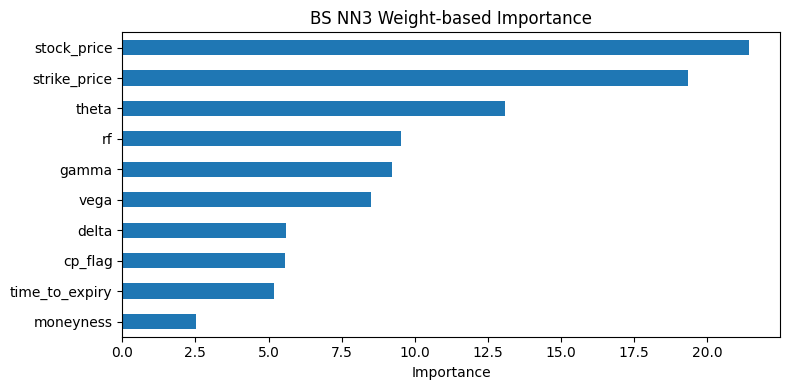

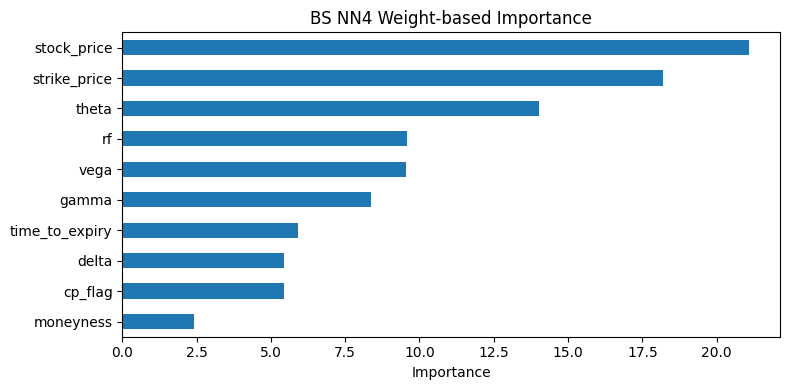

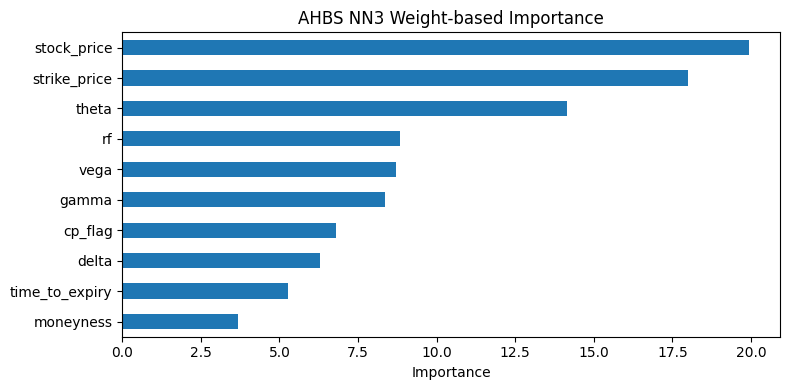

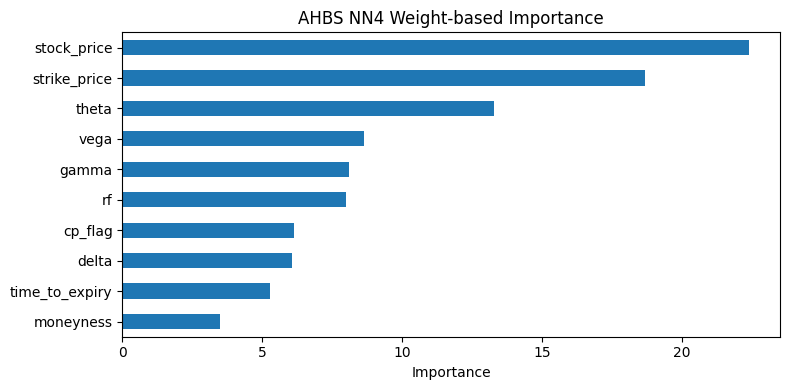

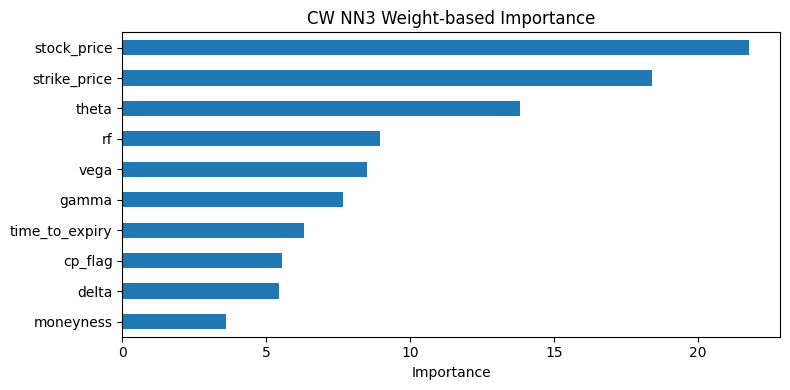

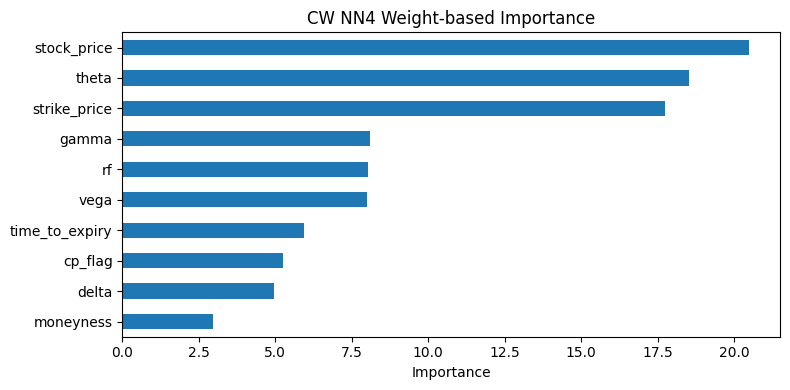

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def weight_importance(model, feature_names: list[str]) -> pd.Series:
    """
    Compute feature importance as normalized mean absolute weights of the first dense layer.
    """
    # Extract weights of first layer (input_size x units)
    w = model.layers[0].get_weights()[0]
    imp = np.abs(w).mean(axis=1)
    imp = imp / imp.sum() * 100
    return pd.Series(imp, index=feature_names).sort_values(ascending=False)


def permutation_importance_nn(model, X: np.ndarray, y: np.ndarray,
                              feature_names: list[str],
                              n_repeats: int = 10,
                              random_state: int = 42) -> pd.Series:
    """
    Compute permutation importance for a Keras model using sklearn's function.
    """
    predict_fn = lambda data: model.predict(data, verbose=0).flatten()
    r = permutation_importance(
        predict_fn, X, y,
        n_repeats=n_repeats,
        random_state=random_state
    )
    return pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)


def plot_importance(importance: pd.Series, top_n: int = 20, title: str = "Feature Importance"):
    """
    Plot horizontal bar chart for the top_n features.
    """
    data = importance.head(top_n).sort_values()
    plt.figure(figsize=(8, max(4, 0.2 * top_n)))
    data.plot.barh()
    plt.xlabel('Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:

feature_names = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network forecast\Option Only\feature_columns.pkl')

groups = ['bs', 'ahbs', 'cw']
arches = ['NN3', 'NN4']

for grp in groups:
    for arch in arches:
        if grp in loaded_models and arch in loaded_models[grp]:
            model = loaded_models[grp][arch]
            imp_w = weight_importance(model, feature_names)
            title = f"{grp.upper()} {arch} Weight-based Importance"
            plot_importance(imp_w, top_n=20, title=title)
        else:
            print(f"⚠️ Model not found for group '{grp}' and architecture '{arch}'. Skipping.")




Performance graphs

In [7]:
sample_df = test_data[1].sample(n=100000, random_state=42)


Evaluating bs NN3


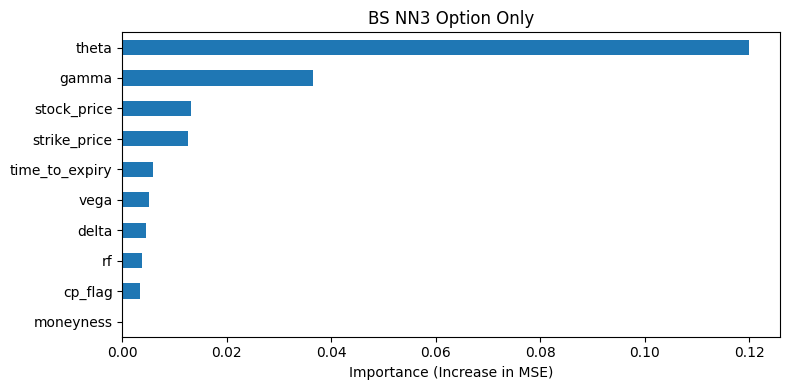

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import joblib

def manual_permutation_importance(model, X: np.ndarray, y: np.ndarray,
                                  feature_names: list[str],
                                  n_repeats: int = 10,
                                  random_state: int = 42) -> pd.Series:

    rng = np.random.RandomState(random_state)
    baseline_preds = model.predict(X, verbose=0).flatten()
    baseline_score = mean_squared_error(y, baseline_preds)

    importances = []
    for idx, col in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, idx] = rng.permutation(X_permuted[:, idx])
            permuted_preds = model.predict(X_permuted, verbose=0).flatten()
            score = mean_squared_error(y, permuted_preds)
            scores.append(score - baseline_score)
        importances.append(np.mean(scores))

    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

def plot_importance(importance: pd.Series, top_n: int = 20, title: str = "Feature Importance"):
    """
    Plot horizontal bar chart for the top_n features.
    """
    data = importance.head(top_n).sort_values()
    plt.figure(figsize=(8, max(4, 0.2 * top_n)))
    data.plot.barh()
    plt.xlabel('Importance (Increase in MSE)')
    plt.title(title)
    plt.xlim(left=0)  # <- This forces the bars to start at zero
    plt.tight_layout()
    plt.show()

# Prepare data once
X_test_scaled, y_test_dict, _, _ = prepare_data(sample_df, save_paths=False)

groups = ['bs']
arches = ['NN3']

# Load pre-saved feature columns (if different than current feature_names)
feature_columns = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network forecast\Option Only\feature_columns.pkl')


for grp in groups:
    y_test = y_test_dict[grp]

    for arch in arches:
        print(f"Evaluating {grp} {arch}")

        # Example: load model here if you have separate models per architecture
        # model = load_model_for_architecture(arch)

        imp_perm = manual_permutation_importance(model, X_test_scaled.values, y_test.values, feature_columns)
        title = f"{grp.upper()} {arch} Option Only"
        plot_importance(imp_perm, top_n=20, title=title)

